In [108]:
from sklearn.decomposition import PCA
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

We are using the training set 2 because we need to understand how to tune the threshold on the reconstruction error that we obtain using PCA.

In [109]:
file_name = "trn_set_2"
DATA_PATH = r"C:../data/{}.csv".format(file_name)

data_trn_2 = pd.read_csv(DATA_PATH, header=0, parse_dates=['DATETIME'], index_col='DATETIME', dayfirst=True)
data_trn_2.index = pd.DatetimeIndex(data_trn_2.index.values, freq = data_trn_2.index.inferred_freq)

discrete_variables = [f'S_PU{num+1}' for num in range(11)] + ['S_V2']    
data_trn_2 = data_trn_2.drop(columns=discrete_variables)

labels = data_trn_2['ATT_FLAG']

data_trn_2.drop(columns=['ATT_FLAG'], inplace=True)

print(data_trn_2.shape)

(4177, 31)


In [110]:
labels = labels.map({-999: 0, 1: 50})

First of all... NORMALIZATION!

In [111]:
normalized_df=(data_trn_2-data_trn_2.mean())/data_trn_2.std()
# normalized_df.head()

# remove columns with NaN (they had only the same value --> not possible to normalize them)
normalized_df.dropna(axis='columns', inplace=True)
# normalized_df.head()

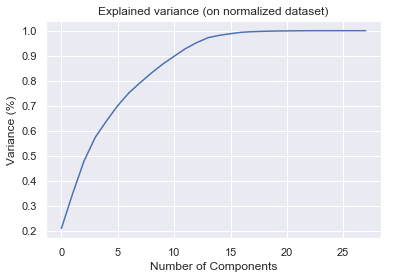

In [112]:
n_of_components = normalized_df.shape[1]
pca_fit = PCA(n_of_components).fit(normalized_df)

plt.figure()
plt.plot(np.cumsum(pca_fit.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained variance (on normalized dataset)')
plt.show()

Let's create a function that retrieves the number of principal components that we need if we want to capture a certain percentage of variance in the data

In [113]:
def get_num_of_principal_components(fitted_pca, desired_variance_perc=90):
    cumulative_variance = np.cumsum(fitted_pca.explained_variance_ratio_)
    return [i for i in range(len(cumulative_variance)) if cumulative_variance[i] > desired_variance_perc/100][0]

Let's use this number of components to project the data into a lower dimensional feature space.

In [114]:
n = get_num_of_principal_components(pca_fit, 90)
print(n)

pca = PCA(n_components=n)
df_pca = pd.DataFrame(pca.fit_transform(normalized_df), normalized_df.index)
df_pca.head()

11


,0,1,2,3,4,5,6,7,8,9,10
2016-07-04 00:00:00,-0.082076,-0.837768,1.910539,2.145791,1.294063,-1.166258,-1.458788,0.226568,-1.189055,0.031432,1.118735
2016-07-04 01:00:00,0.661386,2.600156,2.744080,1.470052,-1.703855,1.445069,-1.978774,0.401720,-1.774352,1.077956,0.931485
2016-07-04 02:00:00,0.925890,2.914836,2.525965,1.639343,-2.824240,1.842735,-0.503091,-0.494060,-0.772674,0.582032,1.729653
2016-07-04 03:00:00,-1.312981,3.521166,1.776369,0.520519,1.390012,2.456869,2.991623,-1.123716,0.101006,-0.724975,0.535529
2016-07-04 04:00:00,-0.972529,4.012716,1.987852,-0.219327,2.350951,2.223345,1.155874,-0.239861,-0.016152,-0.271528,-0.834553


Let's now reconstruct the original data from the lower-dimensional projection that we obtain with PCA

In [115]:
df_reconstructed = pd.DataFrame(pca.inverse_transform(df_pca), normalized_df.index)
df_reconstructed.columns = normalized_df.columns

# print(normalized_df.shape)
# print(df_reconstructed.shape)

# Now, we compute the residuals: original normalized data - reconstructed data

residual_df = normalized_df.subtract(df_reconstructed)

### PCA (finally :D )

We want to see what the residual obtained with PCA reconstruction is. We use sensors for which we know there has been attacks in this training set.

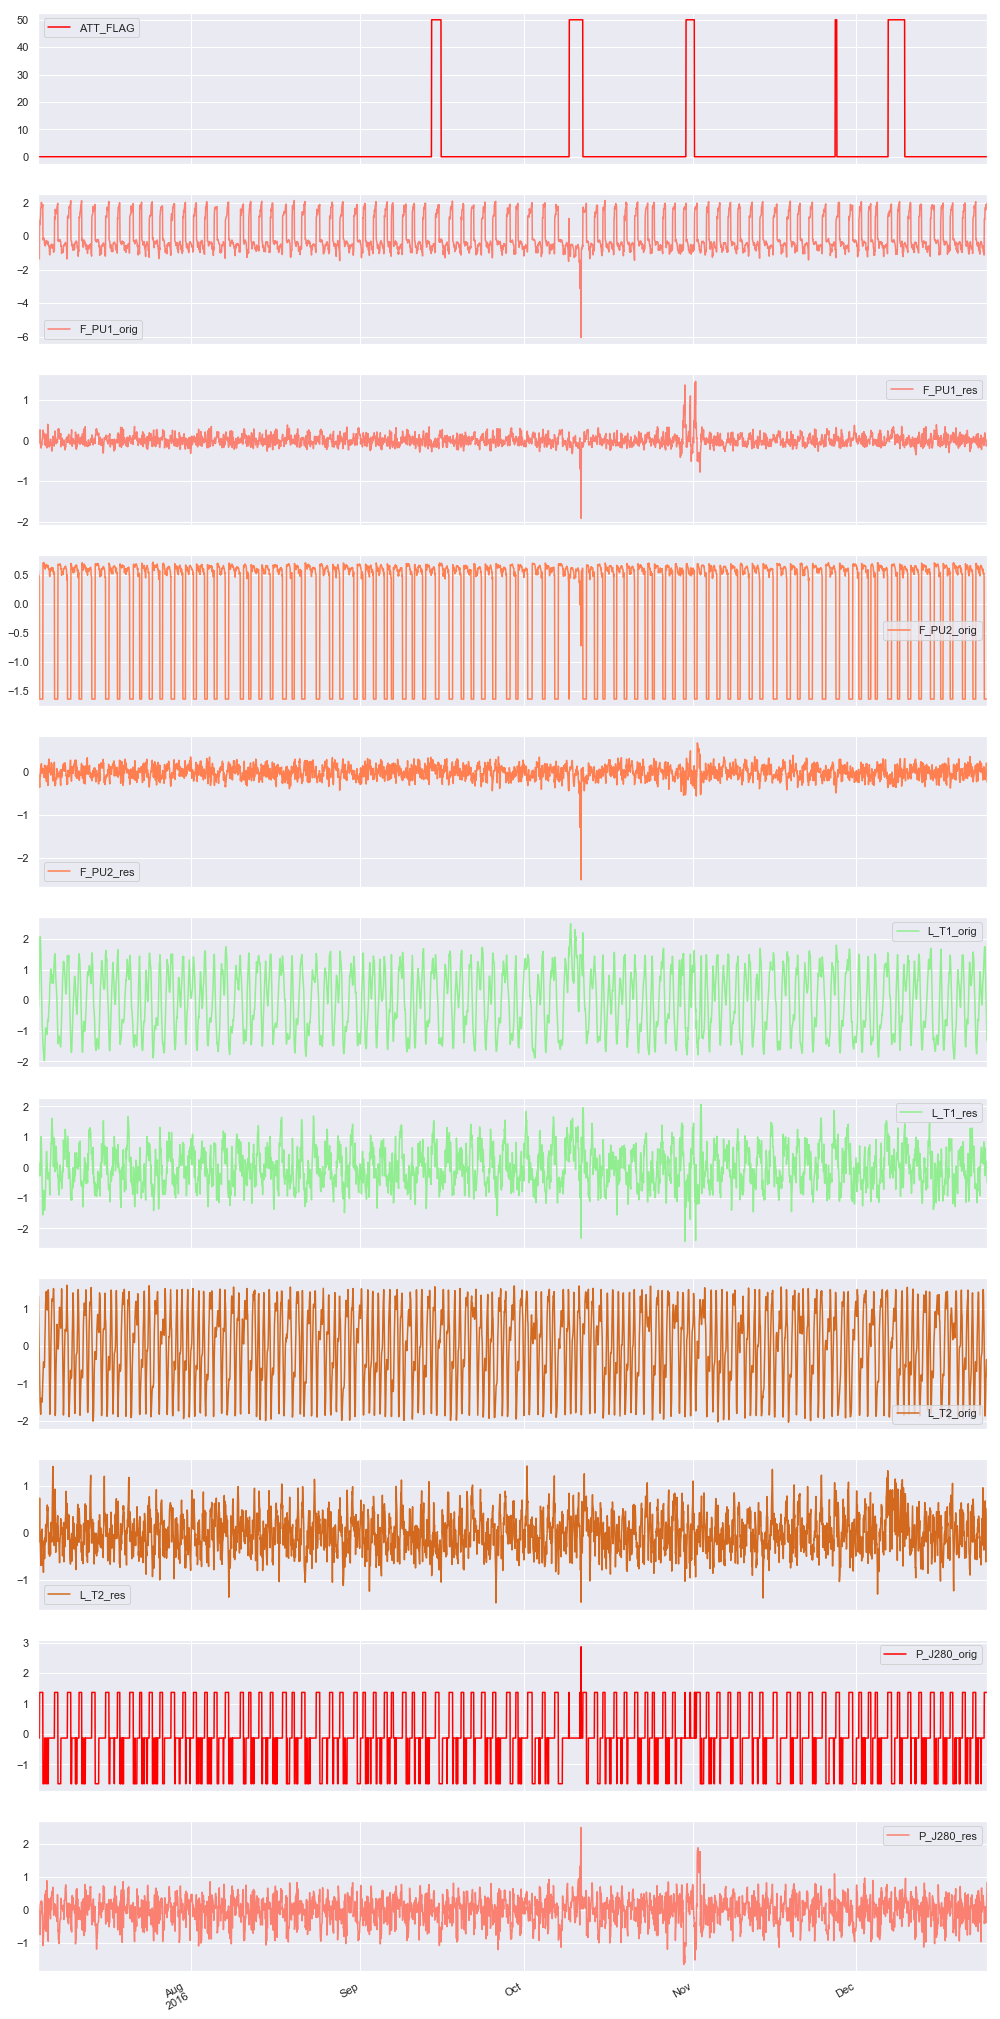

In [116]:
cols_plot = ['L_T1', 'F_PU1', 'F_PU2', 'P_J280', 'L_T2']
original = normalized_df[cols_plot]
original.columns = [col + "_orig" for col in cols_plot]

residuals = residual_df[cols_plot]
residuals.columns = [col + "_res" for col in cols_plot]


to_plot_df = pd.concat([original, residuals, labels], axis=1)
to_plot_df.index = normalized_df.index

to_plot_df = to_plot_df[sorted(to_plot_df.columns)] # this is done just to reorder them and having an ordered plot

# to_plot_df.loc['2016-10-01':'2016-11-10'].plot(figsize=(17, 40), subplots=True, color=['red', 'salmon', 'salmon', 'coral', 'coral', 'lightgreen', 'lightgreen', 'chocolate', 'chocolate'])
to_plot_df.plot(figsize=(17, 40), subplots=True, color=['red', 'salmon', 'salmon', 'coral', 'coral', 'lightgreen', 'lightgreen', 'chocolate', 'chocolate'])
plt.show()

It seems like PCA is actually able to detect some of the anomalies (other attacks are related to other sensors which are not displayed here!)

Let's now square the residuals (we are not interested in the sign) and sum across all the sensors --> we have an overall idea of the PCA residuals over the whole system

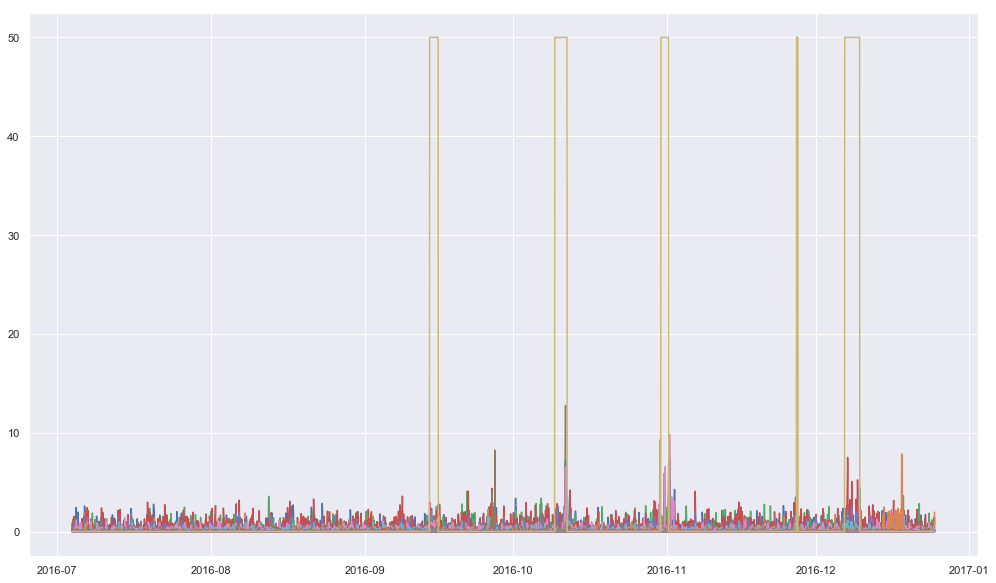

In [117]:
squared_res_df = pd.DataFrame(np.power(residual_df, 2), residual_df.index)

# Let's just have a look at the different residuals altogether (and also labels, why not)
to_plot_df = pd.concat([squared_res_df, labels], axis=1)
plt.figure(figsize=(17,10))
plt.plot(to_plot_df)
plt.show()

Now, let's sum all these squared residuals

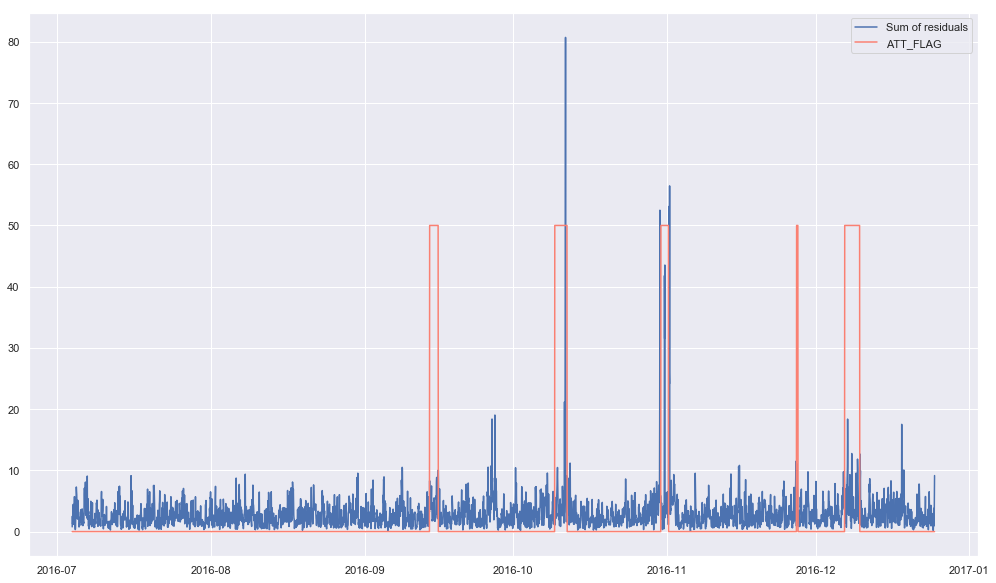

In [123]:
squared_sum_res = squared_res_df.sum(axis=1)
plt.figure(figsize=(17,10))
plt.plot(squared_sum_res, label='Sum of residuals')
plt.plot(labels, color='salmon')
plt.legend()
plt.show()